In [1]:
# Basic packages always been used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data scaling
from sklearn.preprocessing import MinMaxScaler

# Function for spilting training & testing data set
from sklearn.model_selection import train_test_split

# Tensorflow sequential models
from tensorflow import keras
from keras import backend as clear
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.optimizers import SGD
from keras.optimizers import Adam

# Functions for evaluation
from sklearn.metrics import mean_absolute_error #MAE
from sklearn.metrics import mean_squared_error #MSE,RMSE
from sklearn.metrics import mean_absolute_percentage_error #MAPE

# Note: Some metrics need to be defined manually

In [2]:
# Symmetric Mean Absolute Percentage Error (SMAPE)
def SMAPE_calulate(y_true, y_pred):
    n = len(y_true)
    SMAPE=(100 / n) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))
    return SMAPE

# Relative Absolute Error (RAE)
def RAE_calculate(y_true, y_pred):
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    return RAE

# Mean Relative Absolute Error (MRAE)
def MRAE_calculate(y_true, y_pred):
    n=len(y_true)
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    MRAE=RAE/n
    return MRAE

# Median Relative Absolute Error (MdRAE) comparing with benchmark
# Note: By default, the bench value is the mean of actual value
def MdRAE_calculate(y_true, y_pred, bench=None):
    if bench==None:
        bench=np.mean(y_true)
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE,bench
    else:
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE
    
# Relative Squared Error (RSE) & Root Relative Squared Error (RRSE)
def RSE_calculate(y_true, y_pred, Root=False):
    mse = np.mean((y_true - y_pred)**2)
    denominator = np.var(y_true)
    RSE=mse/denominator
    
    if Root==True:
        return np.sqrt(RSE)
    else:
        return RSE

In [4]:
#load data(sometimes need to use "/")
#df = pd.read_csv('D:/pythonData/python_demo_data/Rainfall_Forecast.csv')
# Colab
df = pd.read_csv('/content/AAPL-week1.csv')
df

,Date,Close,Lag_1,Lag_2,Lag_3
0,2018/5/14,47.145000,46.577499,47.147499,45.957500
1,2018/5/21,47.560001,47.145000,46.577499,47.147499
2,2018/5/28,47.924999,47.560001,47.145000,46.577499
3,2018/6/4,47.209999,47.924999,47.560001,47.145000
4,2018/6/11,46.230000,47.209999,47.924999,47.560001
...,...,...,...,...,...
254,2023/3/27,164.660004,164.899994,160.250000,155.000000
255,2023/4/3,165.210007,164.660004,164.899994,160.250000
256,2023/4/10,165.020004,165.210007,164.660004,164.899994
257,2023/4/17,169.679993,165.020004,165.210007,164.660004


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Preparations for time-series data

Note: Pandas has a specific data type for time-series data

In [6]:
# 1.1 Convert date
#df['Date']=pd.to_datetime(df.iloc[:,[0,1,2]])
#df

In [7]:
# Date is converted into special data type of pandas
#df.info()
#df

In [8]:
#new_df=df.iloc[:,[4,3]].copy()
#new_df.head()

In [9]:
# View descriptive statistics of target variable
# Pandas will automatically ignore date if the correct data type has been converted
df.describe()

,Close,Lag_1,Lag_2,Lag_3
count,259.000000,259.000000,259.000000,259.000000
mean,106.029372,105.572143,105.099044,104.639344
std,45.660615,45.660736,45.628708,45.622441
min,37.064999,37.064999,37.064999,37.064999
25%,55.076250,54.766250,54.696251,54.560000
50%,119.989998,119.260002,119.019997,118.690002
75%,147.540001,147.190002,147.074997,146.979996
max,179.449997,179.449997,179.449997,179.449997


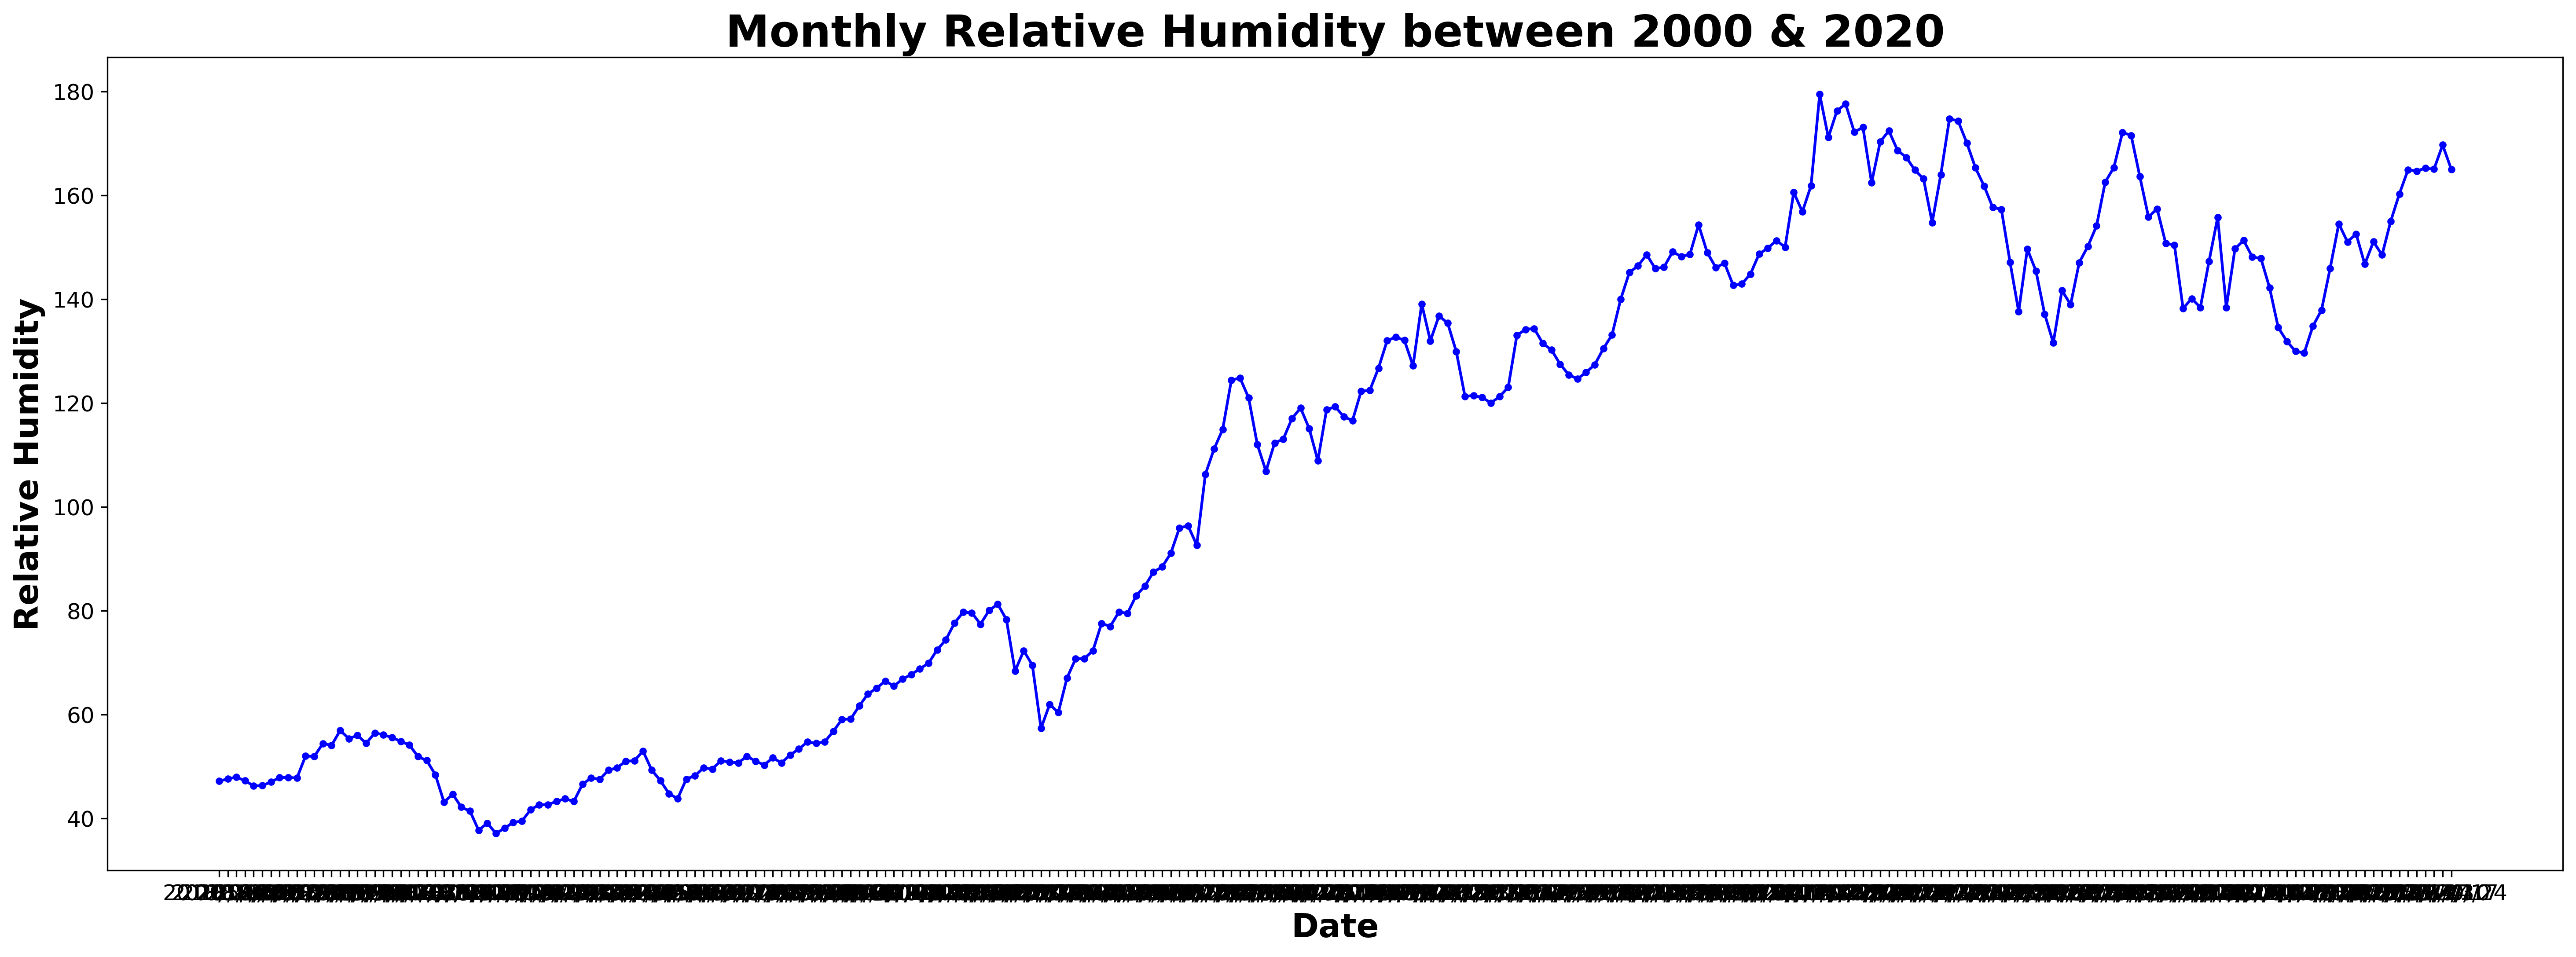

In [10]:
# Plot Y and its corresponding date
# Figure setting
plt.figure(figsize=(24,8),dpi=300)
plt.title('Monthly Relative Humidity between 2000 & 2020',weight='bold',fontsize=24)
plt.xlabel('Date',fontsize=18,weight='bold')
plt.ylabel('Relative Humidity',fontsize=18,weight='bold')

# Actual by predicted plot
plt.plot(df['Date'],df['Close'],marker='.',color='blue')

# Set the axis
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# 2. Creating time lags as predictor variables

# Important!: Be caution when dealing with time-series data

python do have various packages and function that can deal with time-series data with ease, however, make sure that you understand the fundamental first!

In [11]:
# Create 3 lags
#new_df['Lag_1']=new_df['Y'].shift(1).copy()
#new_df['Lag_2']=new_df['Y'].shift(2).copy()
#new_df['Lag_3']=new_df['Y'].shift(3).copy()
df.head()


,Date,Close,Lag_1,Lag_2,Lag_3
0,2018/5/14,47.145000,46.577499,47.147499,45.957500
1,2018/5/21,47.560001,47.145000,46.577499,47.147499
2,2018/5/28,47.924999,47.560001,47.145000,46.577499
3,2018/6/4,47.209999,47.924999,47.560001,47.145000
4,2018/6/11,46.230000,47.209999,47.924999,47.560001


In [12]:
# Drop out missing values and rest index
clean_df=df.dropna(axis=0, how='any').copy()
clean_df=clean_df.reset_index(drop=True)
clean_df

,Date,Close,Lag_1,Lag_2,Lag_3
0,2018/5/14,47.145000,46.577499,47.147499,45.957500
1,2018/5/21,47.560001,47.145000,46.577499,47.147499
2,2018/5/28,47.924999,47.560001,47.145000,46.577499
3,2018/6/4,47.209999,47.924999,47.560001,47.145000
4,2018/6/11,46.230000,47.209999,47.924999,47.560001
...,...,...,...,...,...
254,2023/3/27,164.660004,164.899994,160.250000,155.000000
255,2023/4/3,165.210007,164.660004,164.899994,160.250000
256,2023/4/10,165.020004,165.210007,164.660004,164.899994
257,2023/4/17,169.679993,165.020004,165.210007,164.660004


In [13]:
# Export the data
#clean_df.to_csv('D:/data_analysis/PyExport/Rainfall_Lags.csv',index=False, header=True)
# Colab
#clean_df.to_csv('Rainfall_Lags.csv',index=False, header=True)

# 3. Data preprocessing under time-series structure

A total of 21 years are in the data set. In this practice, we will use the last three years of data as the testing set

In [14]:
# Train data
Forecast_train_data=clean_df.iloc[0:207,:].copy()
Forecast_train_data

,Date,Close,Lag_1,Lag_2,Lag_3
0,2018/5/14,47.145000,46.577499,47.147499,45.957500
1,2018/5/21,47.560001,47.145000,46.577499,47.147499
2,2018/5/28,47.924999,47.560001,47.145000,46.577499
3,2018/6/4,47.209999,47.924999,47.560001,47.145000
4,2018/6/11,46.230000,47.209999,47.924999,47.560001
...,...,...,...,...,...
202,2022/3/28,170.089996,174.309998,174.720001,163.979996
203,2022/4/4,165.289993,170.089996,174.309998,174.720001
204,2022/4/11,161.789993,165.289993,170.089996,174.309998
205,2022/4/18,157.649994,161.789993,165.289993,170.089996


In [16]:
# Test data
Forecast_test_data=clean_df.iloc[207:207+52,:].copy()
Forecast_test_data

,Date,Close,Lag_1,Lag_2,Lag_3
207,2022/5/2,147.110001,157.279999,157.649994,161.789993
208,2022/5/9,137.589996,147.110001,157.279999,157.649994
209,2022/5/16,149.639999,137.589996,147.110001,157.279999
210,2022/5/23,145.380005,149.639999,137.589996,147.110001
211,2022/5/30,137.130005,145.380005,149.639999,137.589996
212,2022/6/6,131.559998,137.130005,145.380005,149.639999
213,2022/6/13,141.660004,131.559998,137.130005,145.380005
214,2022/6/20,138.929993,141.660004,131.559998,137.130005
215,2022/6/27,147.039993,138.929993,141.660004,131.559998
216,2022/7/4,150.169998,147.039993,138.929993,141.660004


# 4. Prepare time-series data for train/validation structure manually

Here we have a total of 18 years of data in training data set that are ready to be further splitted into training and validation data set

18 years of data can be evenlly divided into 6 portions (3 years in each portion)

# Expanding window

In [17]:
# Expanding 1
Exp_training_1=Forecast_train_data.iloc[0:105,:].copy()
Exp_val_1=Forecast_train_data.iloc[105:105+34,:].copy()

# Expanding 2
Exp_training_2=Forecast_train_data.iloc[0:105+34,:].copy()
Exp_val_2=Forecast_train_data.iloc[105+34:105+34+34,:].copy()

# Expanding 3
Exp_training_3=Forecast_train_data.iloc[0:105+34+34,:].copy()
Exp_val_3=Forecast_train_data.iloc[105+34+34:105+34+34+34,:].copy()

Exp_val_3

,Date,Close,Lag_1,Lag_2,Lag_3
173,2021/9/6,146.059998,148.970001,154.300003,148.600006
174,2021/9/13,146.919998,146.059998,148.970001,154.300003
175,2021/9/20,142.649994,146.919998,146.059998,148.970001
176,2021/9/27,142.899994,142.649994,146.919998,146.059998
177,2021/10/4,144.839996,142.899994,142.649994,146.919998
178,2021/10/11,148.690002,144.839996,142.899994,142.649994
179,2021/10/18,149.800003,148.690002,144.839996,142.899994
180,2021/10/25,151.279999,149.800003,148.690002,144.839996
181,2021/11/1,149.990005,151.279999,149.800003,148.690002
182,2021/11/8,160.550003,149.990005,151.279999,149.800003


# Rolling window

In [18]:
# Rolling 1
Rol_training_1=Forecast_train_data.iloc[0:105,:].copy()
Rol_val_1=Forecast_train_data.iloc[105:105+34,:].copy()

# Rolling 2
Rol_training_2=Forecast_train_data.iloc[0:105+34,:].copy()
Rol_val_2=Forecast_train_data.iloc[105+34:105+34+34,:].copy()

# Rolling 3
Rol_training_3=Forecast_train_data.iloc[0:105+34+34,:].copy()
Rol_val_3=Forecast_train_data.iloc[105+34+34:105+34+34+34,:].copy()

Rol_val_3

,Date,Close,Lag_1,Lag_2,Lag_3
173,2021/9/6,146.059998,148.970001,154.300003,148.600006
174,2021/9/13,146.919998,146.059998,148.970001,154.300003
175,2021/9/20,142.649994,146.919998,146.059998,148.970001
176,2021/9/27,142.899994,142.649994,146.919998,146.059998
177,2021/10/4,144.839996,142.899994,142.649994,146.919998
178,2021/10/11,148.690002,144.839996,142.899994,142.649994
179,2021/10/18,149.800003,148.690002,144.839996,142.899994
180,2021/10/25,151.279999,149.800003,148.690002,144.839996
181,2021/11/1,149.990005,151.279999,149.800003,148.690002
182,2021/11/8,160.550003,149.990005,151.279999,149.800003


# 5. Set dependent variable(Y or target) & independent variable(X) 

In [19]:
#set x (make prediction)
# Train
x_train=Exp_training_3.drop(['Date','Close'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 200))
scalingT=MMscaler.fit_transform(x_train)
scaled_x_train=pd.DataFrame(data=scalingT)
scaled_x_train.columns=['Lag_1','Lag_2','Lag_3']

# Validation
x_val=Exp_val_3.drop(['Date','Close'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 200))
scalingV=MMscaler.fit_transform(x_val)
scaled_x_val=pd.DataFrame(data=scalingV)
scaled_x_val.columns=['Lag_1','Lag_2','Lag_3']

#set y (want to predict)
y_train=Exp_training_3['Close'].copy()
y_val=Exp_val_3['Close'].copy()

x_val

,Lag_1,Lag_2,Lag_3
173,148.970001,154.300003,148.600006
174,146.059998,148.970001,154.300003
175,146.919998,146.059998,148.970001
176,142.649994,146.919998,146.059998
177,142.899994,142.649994,146.919998
178,144.839996,142.899994,142.649994
179,148.690002,144.839996,142.899994
180,149.800003,148.690002,144.839996
181,151.279999,149.800003,148.690002
182,149.990005,151.279999,149.800003


In [21]:
#set x (make prediction)
# Train
x_train=Rol_training_1.drop(['Date','Close'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 200))
scalingT=MMscaler.fit_transform(x_train)
scaled_x_train=pd.DataFrame(data=scalingT)
scaled_x_train.columns=['Lag_1','Lag_2','Lag_3']

# Validation
x_val=Rol_val_1.drop(['Date','Close'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 200))
scalingV=MMscaler.fit_transform(x_val)
scaled_x_val=pd.DataFrame(data=scalingV)
scaled_x_val.columns=['Lag_1','Lag_2','Lag_3']

#set y (want to predict)
y_train=Rol_training_1['Close'].copy()
y_val=Rol_val_1['Close'].copy()

y_val

105     79.485001
106     82.875000
107     84.699997
108     87.430000
109     88.407501
110     91.027496
111     95.919998
112     96.327499
113     92.614998
114    106.260002
115    111.112503
116    114.907501
117    124.370003
118    124.807503
119    120.959999
120    112.000000
121    106.839996
122    112.279999
123    113.019997
124    116.970001
125    119.019997
126    115.040001
127    108.860001
128    118.690002
129    119.260002
130    117.339996
131    116.589996
132    122.250000
133    122.410004
134    126.660004
135    131.970001
136    132.690002
137    132.050003
138    127.139999
Name: Close, dtype: float64

# 6. Creating Net 

In [22]:
# Quick recap: Total of 12 features in the data set
scaled_x_train.head()

,Lag_1,Lag_2,Lag_3
0,43.069779,45.650570,40.262608
1,45.639256,43.069779,45.650570
2,47.518257,45.639256,43.069779
3,49.170860,47.518257,45.639256
4,45.933552,49.170860,47.518257


In [23]:
# Tips: Using shape to call the amount of features in the data set 
input_features=scaled_x_train.shape[1]
print('Amount of features:',input_features)

Amount of features: 3


# Important: Define customized loss function (RMSE)

In [24]:
from keras.losses import mse
from keras.backend import sqrt

def my_RMSE(y_true, y_pred):
    return sqrt(mse(y_true, y_pred))

# Register custom object
#from keras.utils.generic_utils import get_custom_objects for pc
from tensorflow.keras.saving import get_custom_objects
get_custom_objects().update({'my_RMSE': my_RMSE})

Note: As far as I know when I'm preparing this in-class material, keras does not have a built-in RMSE function. Rumor has it that a RMSE function is hidden in the latest version, however it needs to be confirmed. For instance, defining RMSE ourself is not difficult, just don't forget to register our custom functions.   

# Sequential style coding for creating net

In [25]:
# 6.1 Create the model
clear.clear_session()
model=Sequential()

# 6.2 Add input layer & first hidden layer
model.add(Dense(units=6, input_dim=3, activation='relu'))

# 6.3 Add second hidden layer
model.add(Dense(units=12, activation='relu'))

# 6.4 Add third hidden layer
model.add(Dense(units=24, activation='relu'))

# 6.5 Add third hidden layer
model.add(Dense(units=48, activation='relu'))

# 6.6 Add third hidden layer
model.add(Dense(units=96, activation='relu'))

# 6.7 Add output layer
model.add(Dense(units=1, activation='relu'))

# 6.8 Compile the defined Net
opt=Adam(learning_rate=0.01,beta_1=0.9)
model.compile(loss='my_RMSE', optimizer=opt, metrics=['mean_absolute_percentage_error'])

# Finally check the model 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 24        
                                                                 
 dense_1 (Dense)             (None, 12)                84        
                                                                 
 dense_2 (Dense)             (None, 24)                312       
                                                                 
 dense_3 (Dense)             (None, 48)                1200      
                                                                 
 dense_4 (Dense)             (None, 96)                4704      
                                                                 
 dense_5 (Dense)             (None, 1)                 97        
                                                                 
Total params: 6,421
Trainable params: 6,421
Non-trainabl

Note: Remember to clear the session or else some of the left neurans may cause trouble while fitting

# 7. Fit the model (train/validation)

In [26]:
# 7.1 Store in the history for more useful information
history=model.fit(scaled_x_train, y_train, epochs=300, batch_size=64,verbose=1,validation_data=(scaled_x_val, y_val))

Epoch 1/300
2/2 [==============================] - 1s 266ms/step - loss: 55.4616 - mean_absolute_percentage_error: 100.0000 - val_loss: 110.9496 - val_mean_absolute_percentage_error: 100.0000
Epoch 2/300
2/2 [==============================] - 0s 34ms/step - loss: 55.4616 - mean_absolute_percentage_error: 100.0000 - val_loss: 110.9496 - val_mean_absolute_percentage_error: 100.0000
Epoch 3/300
2/2 [==============================] - 0s 34ms/step - loss: 55.4616 - mean_absolute_percentage_error: 100.0000 - val_loss: 110.9496 - val_mean_absolute_percentage_error: 100.0000
Epoch 4/300
2/2 [==============================] - 0s 31ms/step - loss: 55.4616 - mean_absolute_percentage_error: 100.0000 - val_loss: 110.9496 - val_mean_absolute_percentage_error: 100.0000
Epoch 5/300
2/2 [==============================] - 0s 32ms/step - loss: 55.4616 - mean_absolute_percentage_error: 100.0000 - val_loss: 110.9496 - val_mean_absolute_percentage_error: 100.0000
Epoch 6/300
2/2 [===========================

In [27]:
# Check the dictionary keys
modeling_result=history.history
modeling_result.keys()

dict_keys(['loss', 'mean_absolute_percentage_error', 'val_loss', 'val_mean_absolute_percentage_error'])

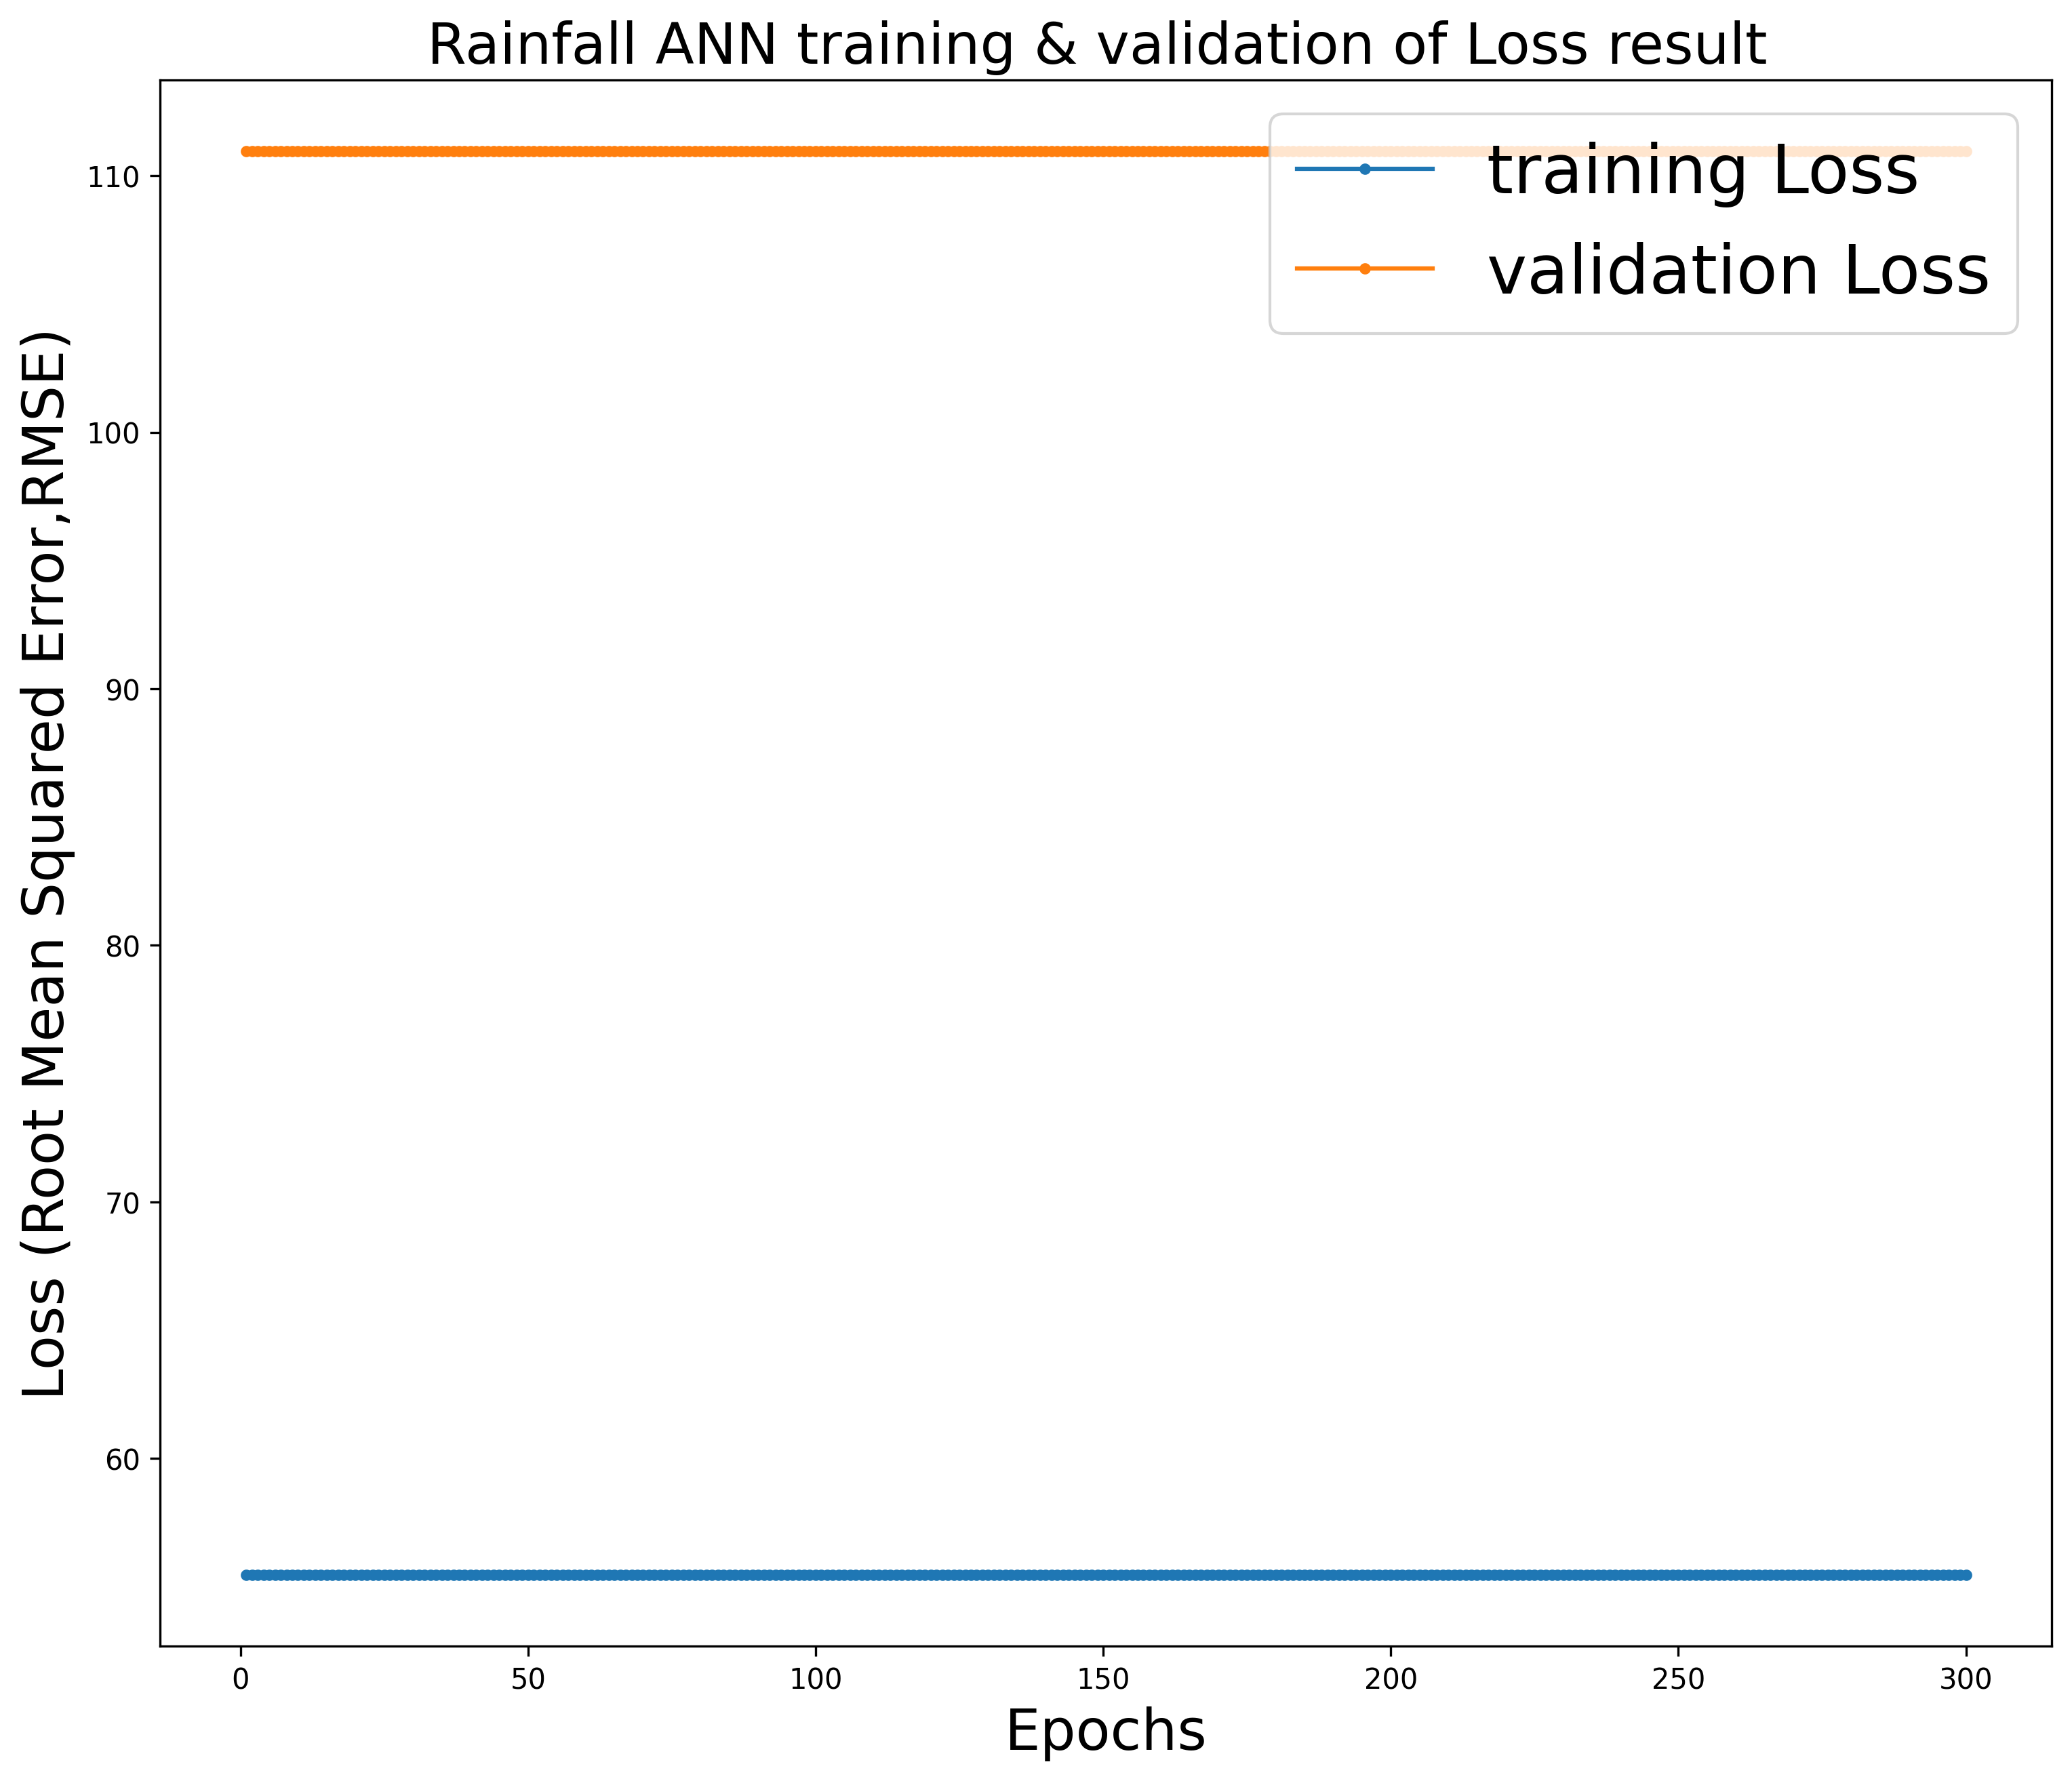

In [28]:
# 7.2 Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Root Mean Squared Error,RMSE)',fontsize=20)
plt.title('Rainfall ANN training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='.',label='training Loss')
plt.plot(epochs, val_loss_values,marker='.',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

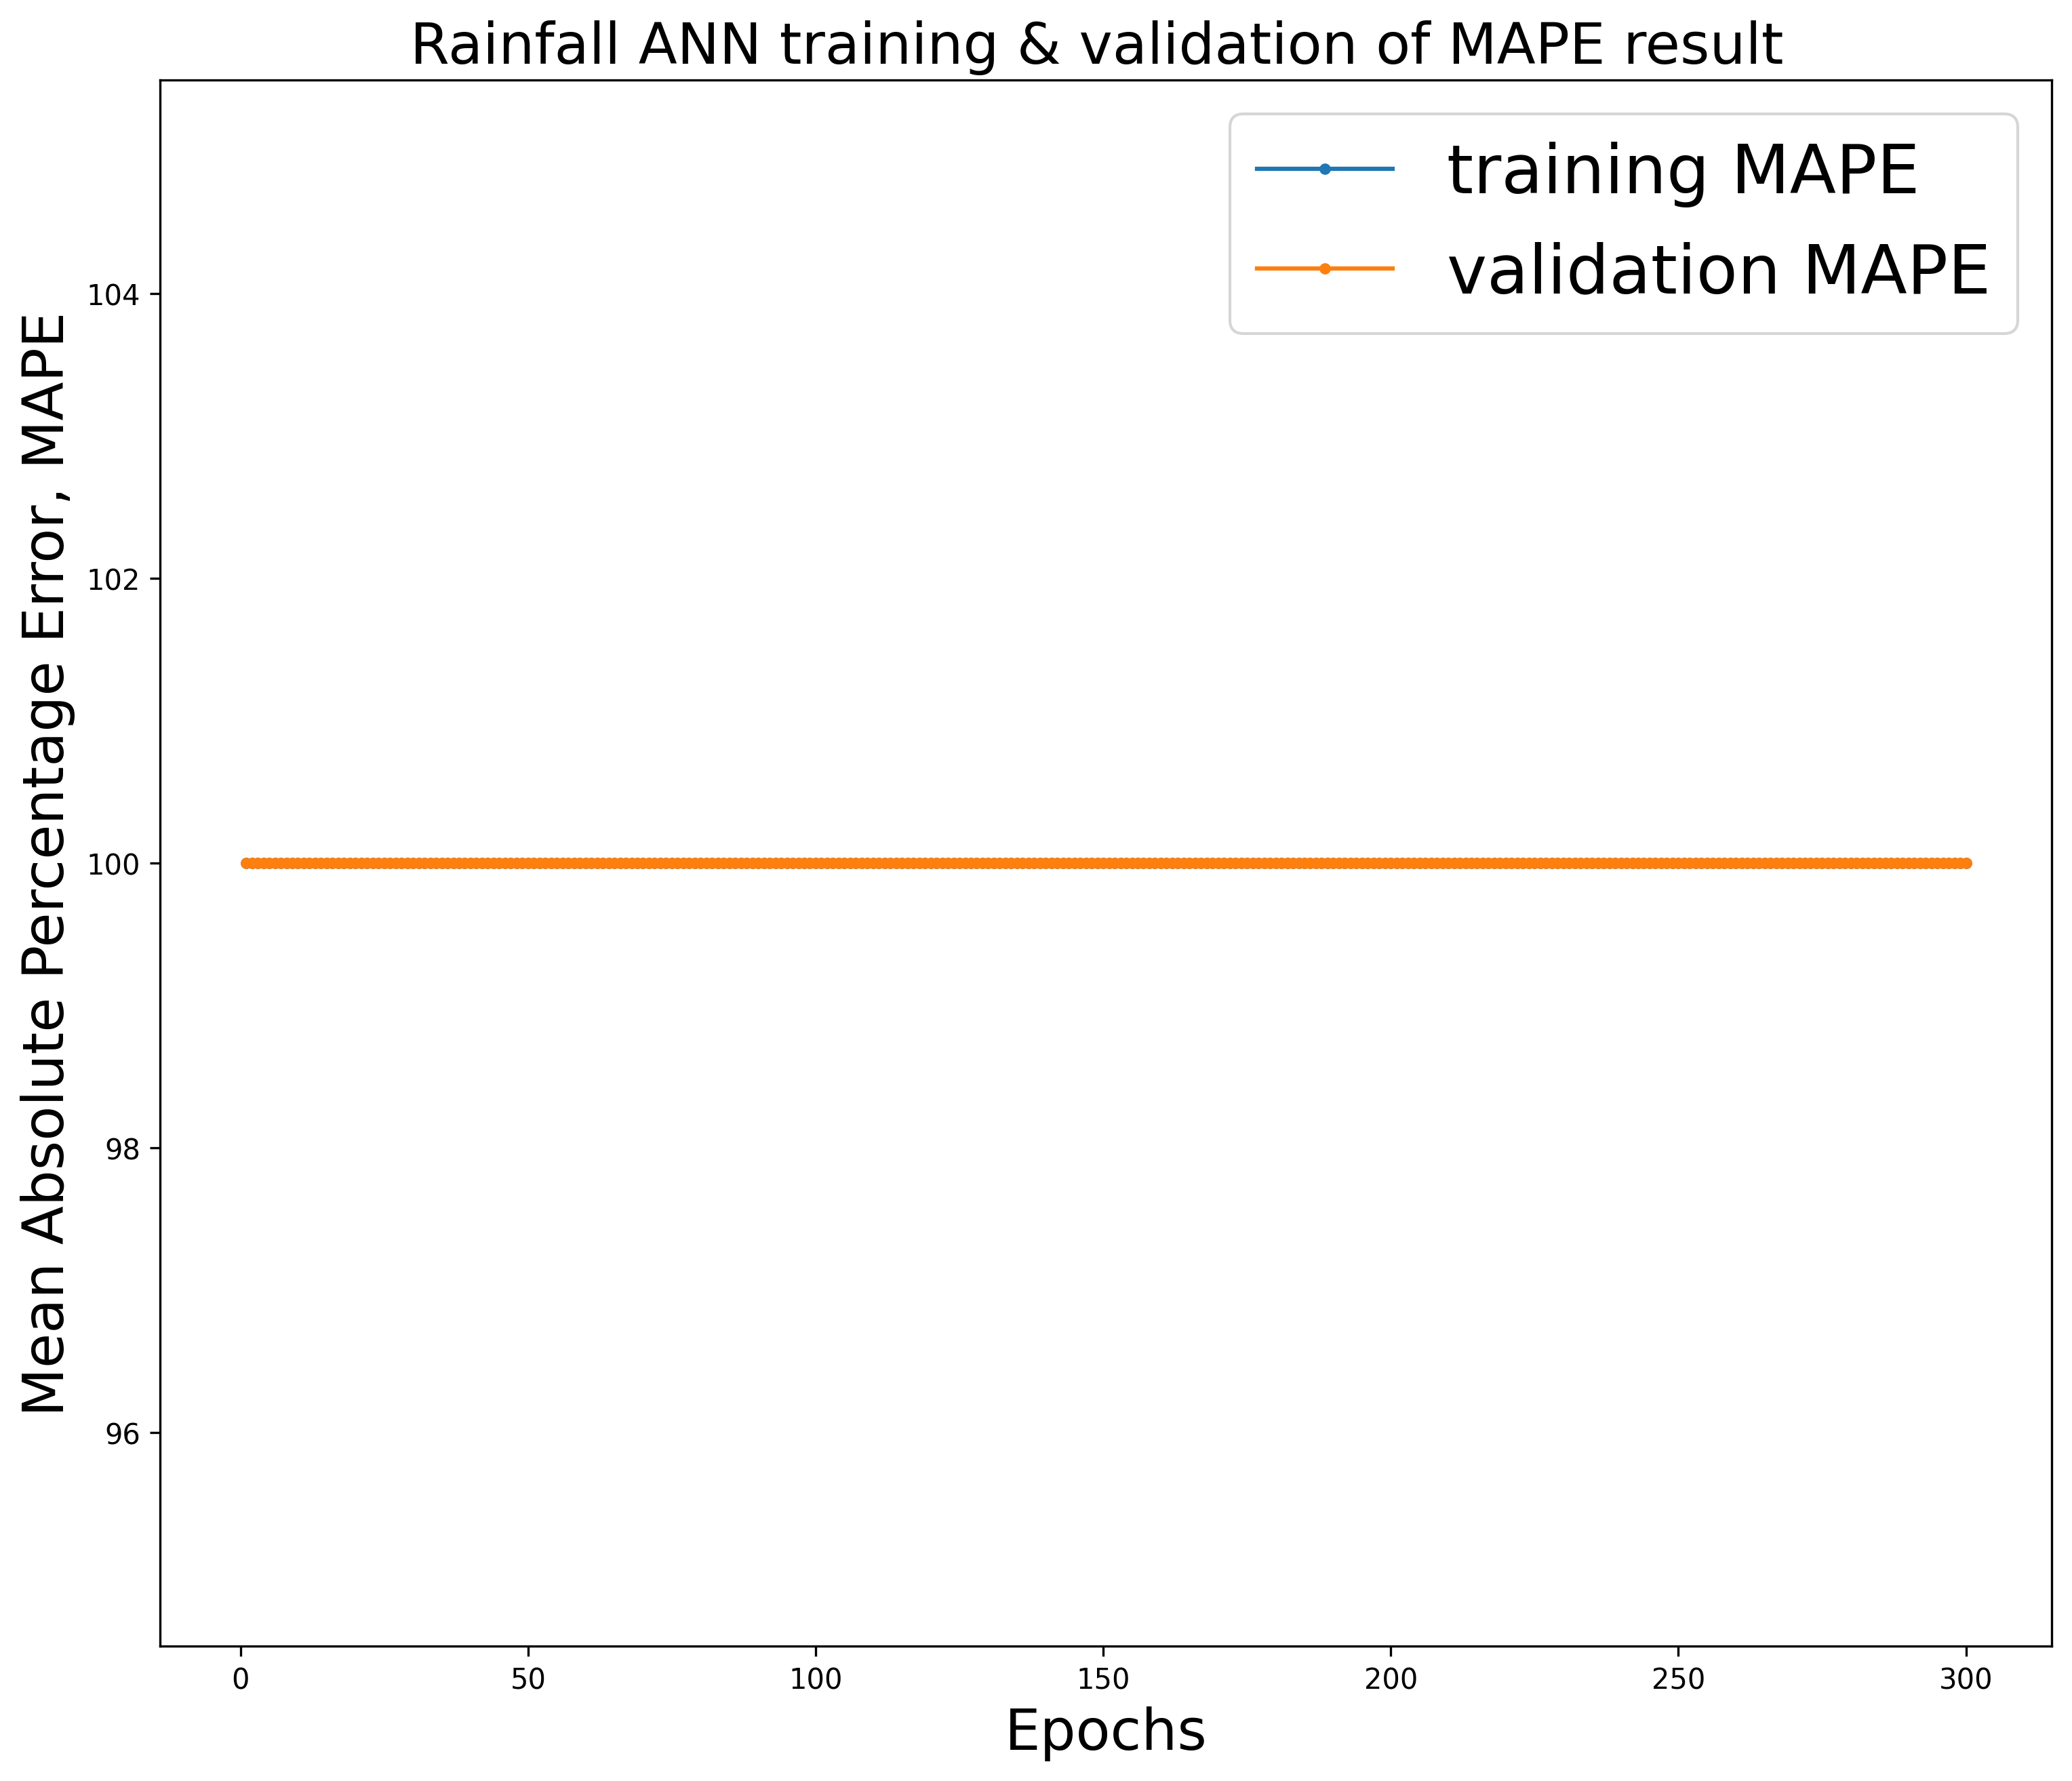

In [29]:
# 7.2 Plot the history of training and validation
training_acc_values=modeling_result['mean_absolute_percentage_error']
val_acc_values=modeling_result['val_mean_absolute_percentage_error']
epochs=range(1,len(training_acc_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Mean Absolute Percentage Error, MAPE',fontsize=20)
plt.title('Rainfall ANN training & validation of MAPE result ',fontsize=20)

plt.plot(epochs, training_acc_values,marker='.',label='training MAPE')
plt.plot(epochs, val_acc_values,marker='.',label='validation MAPE')
plt.legend(loc=1,fontsize=24)
plt.show()

# Fit the final model with all of the training data

In [30]:
# X all train data
x_forecast_train=Forecast_train_data.drop(['Date','Close'],axis=1).copy()
# Y all train data
y_forecast_train=Forecast_train_data['Close'].copy()

In [31]:
# Create the model
clear.clear_session()
Fmodel=Sequential()

# Add input layer & first hidden layer
Fmodel.add(Dense(units=6, input_dim=3, activation='relu'))

# Add second hidden layer
Fmodel.add(Dense(units=12, activation='relu'))

# Add third hidden layer
Fmodel.add(Dense(units=24, activation='relu'))

# Add third hidden layer
Fmodel.add(Dense(units=48, activation='relu'))

# Add third hidden layer
Fmodel.add(Dense(units=96, activation='relu'))

# Add output layer
Fmodel.add(Dense(units=1, activation='relu'))

# Compile the defined Net

opt=Adam(learning_rate=0.01,beta_1=0.9)
Fmodel.compile(loss='my_RMSE', optimizer=opt, metrics=['mean_absolute_percentage_error'])

# Finally check the model 
Fmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 24        
                                                                 
 dense_1 (Dense)             (None, 12)                84        
                                                                 
 dense_2 (Dense)             (None, 24)                312       
                                                                 
 dense_3 (Dense)             (None, 48)                1200      
                                                                 
 dense_4 (Dense)             (None, 96)                4704      
                                                                 
 dense_5 (Dense)             (None, 1)                 97        
                                                                 
Total params: 6,421
Trainable params: 6,421
Non-trainabl

In [32]:
# Store in the history for more useful information
history=Fmodel.fit(x_forecast_train, y_forecast_train, epochs=300, batch_size=64,verbose=1)

Epoch 1/300
4/4 [==============================] - 1s 6ms/step - loss: 78.5914 - mean_absolute_percentage_error: 82.8336
Epoch 2/300
4/4 [==============================] - 0s 4ms/step - loss: 27.0936 - mean_absolute_percentage_error: 28.3676
Epoch 3/300
4/4 [==============================] - 0s 5ms/step - loss: 16.9774 - mean_absolute_percentage_error: 18.1976
Epoch 4/300
4/4 [==============================] - 0s 6ms/step - loss: 19.3057 - mean_absolute_percentage_error: 19.8756
Epoch 5/300
4/4 [==============================] - 0s 6ms/step - loss: 16.1137 - mean_absolute_percentage_error: 17.5703
Epoch 6/300
4/4 [==============================] - 0s 5ms/step - loss: 16.2251 - mean_absolute_percentage_error: 16.6662
Epoch 7/300
4/4 [==============================] - 0s 6ms/step - loss: 9.4328 - mean_absolute_percentage_error: 10.1648
Epoch 8/300
4/4 [==============================] - 0s 6ms/step - loss: 11.0379 - mean_absolute_percentage_error: 12.0631
Epoch 9/300
4/4 [================

In [33]:
# 7.3 Save the trained model
#Fmodel.save('D:/data_analysis/PyExport/Rainfall_forecast_ANN_trained_model.h5')
# Colab
Fmodel.save('House_Rent_ANN_trained_model.h5')
print('Model has been saved...')

Model has been saved...


In [34]:
# 7.4 Restore the saved model for testing
#ANN_model=keras.models.load_model('D:/data_analysis/PyExport/Rainfall_forecast_ANN_trained_model.h5')
# Colab
ANN_model=keras.models.load_model('/content/House_Rent_ANN_trained_model.h5')
print('Model successfully loaded...')

Model successfully loaded...


# 8. Testing

In [35]:
# X test
x_forecast_test=Forecast_test_data.drop(['Date','Close'],axis=1).copy()
# Y test
y_forecast_test=Forecast_test_data['Close'].copy()

In [36]:
# 8.1 Make prediction 
prediction=np.round((ANN_model.predict_on_batch(x_forecast_test)),2)
pred_values=[]
for i in range(0,len(prediction)):
    value=prediction[i][0]
    pred_values.append(value)

In [37]:
Results=pd.DataFrame({'Date':Forecast_test_data['Date'],'Y_true':Forecast_test_data['Close'],'Predict':pred_values})
Results['abs Error']=np.abs(Results['Y_true']-Results['Predict'])
Results

,Date,Y_true,Predict,abs Error
207,2022/5/2,147.110001,163.960007,16.850006
208,2022/5/9,137.589996,153.570007,15.980011
209,2022/5/16,149.639999,144.210007,5.429992
210,2022/5/23,145.380005,155.919998,10.539993
211,2022/5/30,137.130005,148.820007,11.690002
212,2022/6/6,131.559998,143.380005,11.820007
213,2022/6/13,141.660004,137.729996,3.930008
214,2022/6/20,138.929993,147.520004,8.590011
215,2022/6/27,147.039993,142.610001,4.429992
216,2022/7/4,150.169998,153.009995,2.839997


In [38]:
# 8.2 Calculating the mertics
MAE=mean_absolute_error(y_forecast_test,pred_values)
MSE=mean_squared_error(y_forecast_test,pred_values,squared=True)
RMSE=mean_squared_error(y_forecast_test,pred_values,squared=False)
MAPE=mean_absolute_percentage_error(y_forecast_test,pred_values)
SMAPE=SMAPE_calulate(y_forecast_test,pred_values)
RAE=RAE_calculate(y_forecast_test,pred_values)
MRAE=MRAE_calculate(y_forecast_test,pred_values)
MdRAE=MdRAE_calculate(y_forecast_test,pred_values)
RSE=RSE_calculate(y_forecast_test,pred_values,Root=False)
RRSE=RSE_calculate(y_forecast_test,pred_values,Root=True)

print('MAE:',round(MAE,3))
print('MSE:',round(MSE,3))
print('RMSE:',round(RMSE,3))
print('MAPE:',round(MAPE*100,3),'%')
print('SMAPE:',round(SMAPE,3),'%')
print('RAE:',round(RAE,3))
print('MRAE:',MRAE)
print('MdRAE:',round(MdRAE[0],3),'bench:',round(MdRAE[1],3))
print('RSE:',round(RSE,3))
print('RRSE:',round(RRSE,3))

MAE: 7.16
MSE: 77.026
RMSE: 8.776
MAPE: 4.9 %
SMAPE: 4.737 %
RAE: 0.787
MRAE: 0.015134112452478126
MdRAE: 0.822 bench: 149.718
RSE: 0.607
RRSE: 0.779


#  Plot for comparing true value & predicted value 

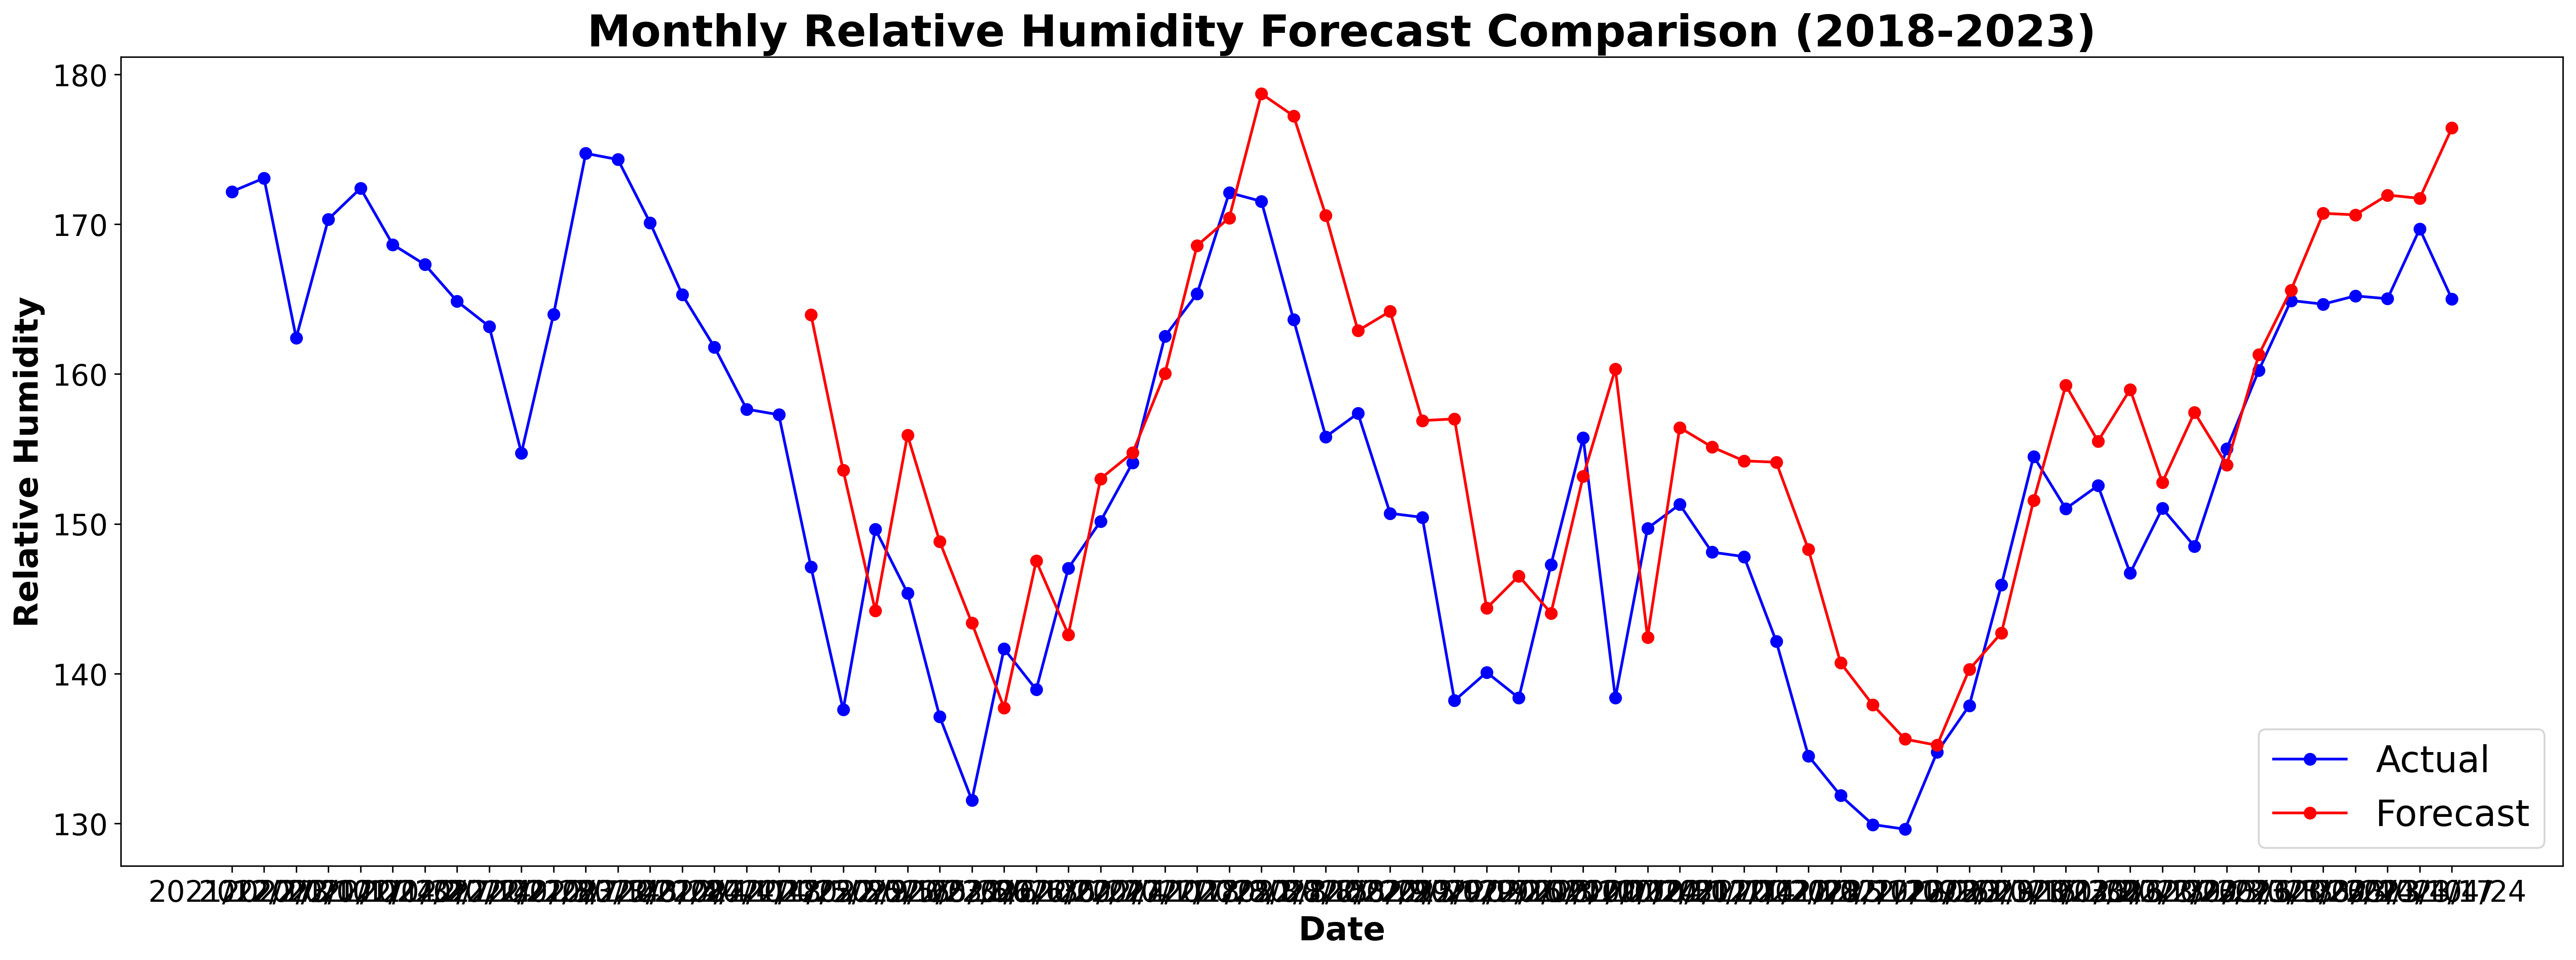

In [39]:
# Plot Y and its corresponding date
# Figure setting
plt.figure(figsize=(24,8),dpi=300)
plt.title('Monthly Relative Humidity Forecast Comparison (2018-2023)',weight='bold',fontsize=24)
plt.xlabel('Date',fontsize=18,weight='bold')
plt.ylabel('Relative Humidity',fontsize=18,weight='bold')

# Comparison of actual value and predicted value according to Date
plt.plot(clean_df.iloc[189:,0],clean_df.iloc[189:,1],marker='o',color='blue',label='Actual')
plt.plot(Results['Date'],Results['Predict'],marker='o',color='red',label='Forecast')

# Set the axis
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Set legends
plt.legend(loc=4,fontsize=20)

plt.show()

# Actual by predicted plot

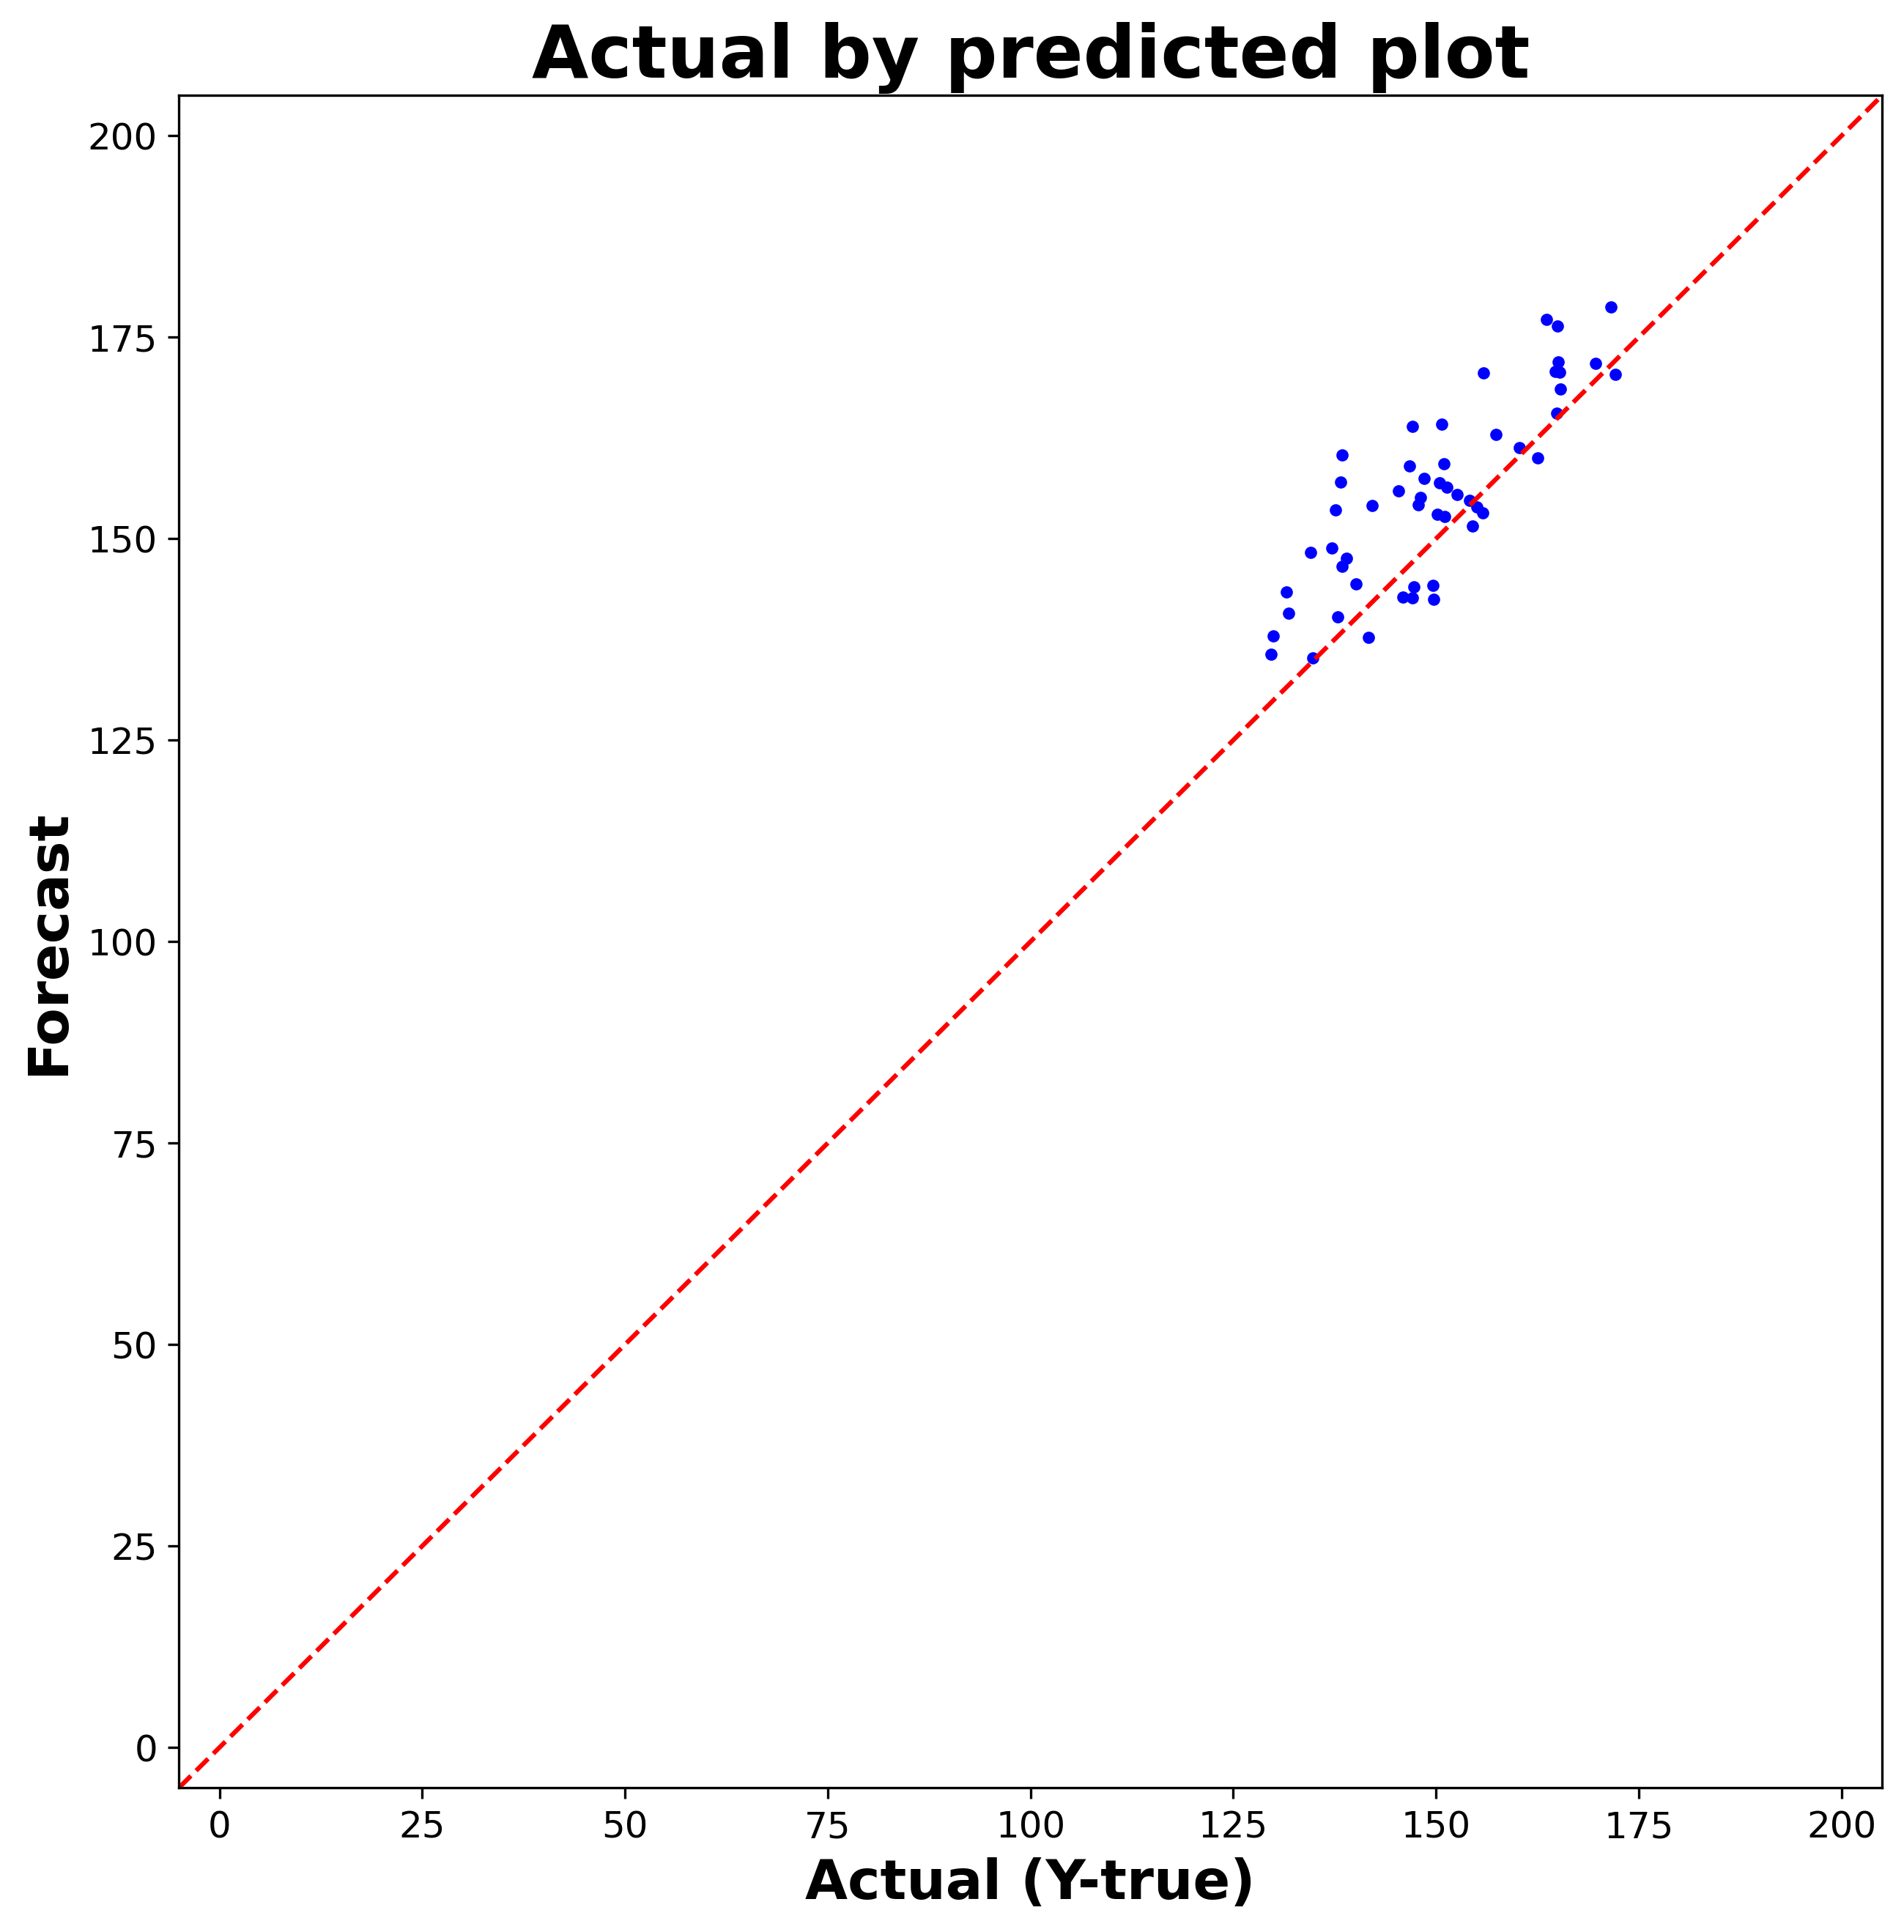

In [40]:
# Lock the scale of axis by Y_true
max_value=200+5
min_value=0-5

# Figure setting
plt.figure(figsize=(10,10),dpi=300)
plt.title('Actual by predicted plot',weight='bold',fontsize=24)
plt.xlabel('Actual (Y-true)',fontsize=18,weight='bold')
plt.ylabel('Forecast',fontsize=18,weight='bold')

# Perfect model reference line
plt.plot([min_value,max_value], [min_value,max_value], linestyle='--',color='red')

# Actual by predicted plot
plt.scatter(Results.iloc[:,1],Results.iloc[:,2],marker='.',color='blue')

# Set the axis
plt.ylim(0-5,max_value)
plt.xlim(0-5,max_value)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()